<a href="https://colab.research.google.com/github/FED32/Fire_detection/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Fire_detection_v03%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В данной работе использовалось:

Датасет
https://github.com/cair/Fire-Detection-Image-Dataset.git

Еще датасет
https://www.kaggle.com/datasets/phylake1337/fire-dataset

Статья
https://habr.com/ru/company/nix/blog/441620/

Еще статья
https://habr.com/ru/post/598617/

Пример моей учебной работы по дообучению сети VGG16
https://www.kaggle.com/code/fed9211/my-cats-vs-dogs

Документация keras
https://keras.io/api/

Документация resnet
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input

Похожие решения
- https://www.kaggle.com/code/delllectron/fire-detection-computer-vision
- https://www.kaggle.com/code/holdmykaggle/fire-detection-in-images/notebook
- https://www.kaggle.com/code/chemamasamuel/fire-detection-96-accuracy/notebook

In [ ]:
import numpy as np
import pandas as pd

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

print(tf.__version__)
print(tf.executing_eagerly())

import os
from random import shuffle
from glob import glob

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm

2.8.0
True


In [ ]:
# монтируем диск
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# загружаем картинки
fire_images = glob('gdrive/MyDrive/Fire_detecting/data/dataset/Fire images 1/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Fire images 2/*.png')

normal_images = glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 1/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 2/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 3/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 4/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 5/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 6/*.png')

shuffle(fire_images)
shuffle(normal_images)

print(f'Количество картинок с пожаром', len(fire_images))
print(f'Количество обычных картинок', len(normal_images))

Количество картинок с пожаром 860
Количество обычных картинок 761


In [ ]:
# размер изображения с которым работаем
IMG_SIZE = (224, 224)

In [ ]:
# функция для отображения картинок
def show_images(files):
    fig = plt.figure(figsize=(16, 8))
    for i, path in enumerate(files[:10], 1):
        subplot = fig.add_subplot(2, 5, i)
        subplot.set_title('%s' % path.split('/')[-1])
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        plt.imshow(img)
    return None

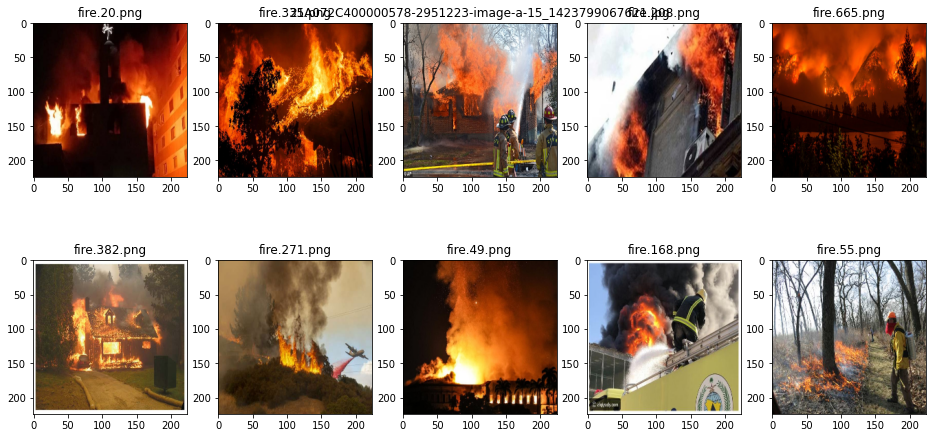

In [ ]:
show_images(fire_images)

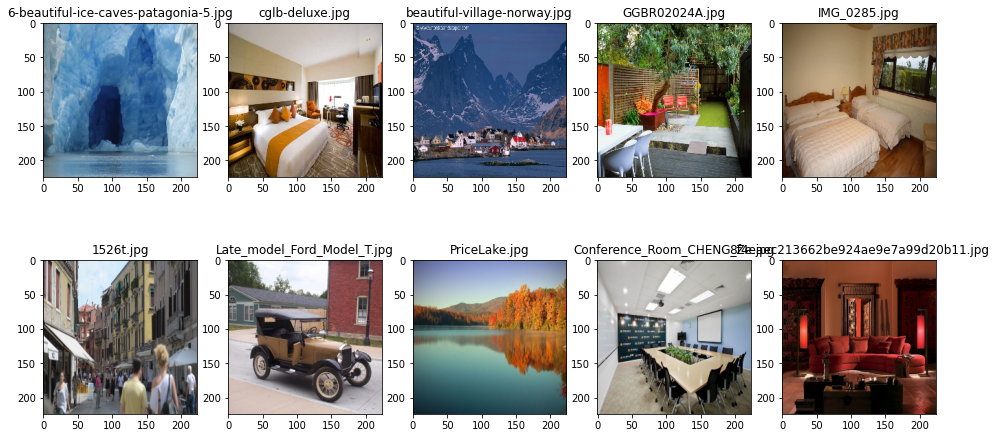

In [ ]:
show_images(normal_images)

In [ ]:
# функция для загрузки и предобработки изображения
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return resnet50.preprocess_input(img, data_format=None)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        # shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1 if os.path.dirname(path).split('/')[-1].startswith('Fire') else 0
                          for path in files[i:j]])
            yield (x, y)
            
            
# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [ ]:
# разбиваем данные на тренировочные и тестовые
def get_train_test(files):
    train = files[:round(len(files)*0.8)]
    test = files[round(len(files)*0.8):]
    return train, test

train_files = get_train_test(fire_images)[0] + get_train_test(normal_images)[0]
test_files = get_train_test(fire_images)[1] + get_train_test(normal_images)[1]

shuffle(train_files)
shuffle(test_files)

print(f'Тренировочных изображений', len(train_files))
print(f'Тестовых изображений', len(test_files))

Тренировочных изображений 1297
Тестовых изображений 324


In [ ]:
# загружаем базовую модель
# base_model - объект класса keras.models.Model (Functional Model)
base_model = resnet50.ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
# x = tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='fire_detector')

In [ ]:
model.summary()

Model: "fire_detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                      

In [ ]:
# компилируем модель
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [ ]:
# настраиваем чекпоинты
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001,
                           patience=10, verbose=1, mode='auto')
chkpt = ModelCheckpoint('gdrive/MyDrive/Fire_detecting/models/fire-datector-resnet50.hdf5', 
                        monitor='loss', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='auto')
callbacks = [early_stop, chkpt]

https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

In [ ]:
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

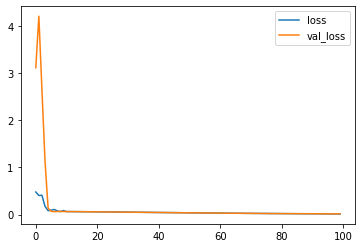


Epoch 100: loss improved from 0.01313 to 0.01284, saving model to gdrive/MyDrive/Fire_detecting/models/fire-datector-resnet50.hdf5
10/10 [==============================] - 13s 1s/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000


In [ ]:
# формируем тренировочные и валидационные данные
val_samples = 5  # число изображений в валидационной выборке
epochs=100

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=epochs,  # число эпох обучения
          validation_data=validation_data,
          callbacks=[plot_losses, callbacks])

In [ ]:
# сохраняем модель
model.save('gdrive/MyDrive/Fire_detecting/models/fire-datector-resnet50.hdf5')

In [ ]:
# model.load_weights('gdrive/MyDrive/Fire_detecting/models/fire-datector-resnet50.hdf5')

In [ ]:
# предсказываем класс тестовых картинок
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files), verbose=1)

324/324 [==============================] - 57s 173ms/step


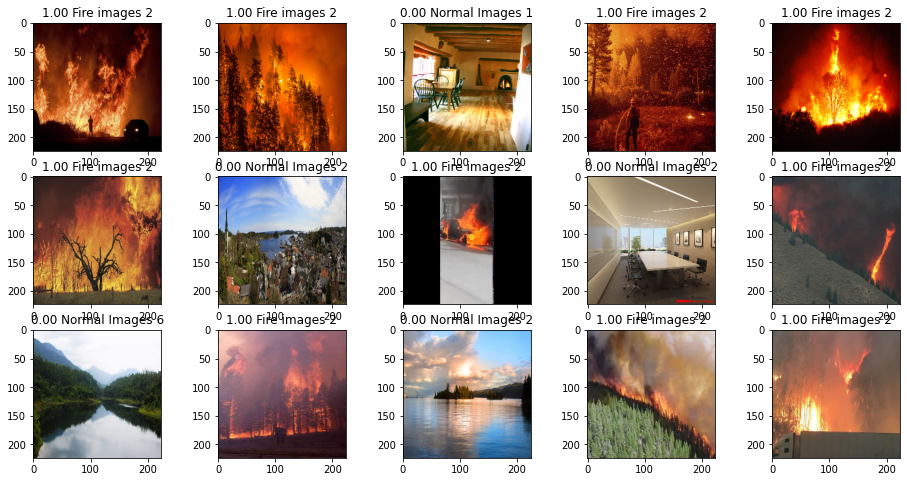

In [ ]:
# визуализируем предсказания
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:15], test_pred[:15]), 1):
    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.dirname(path).split('/')[-1]))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

fig.savefig('gdrive/MyDrive/Fire_detecting/predict')

In [ ]:
# валидация на тренировочных данных
train_score = model.evaluate(fit_generator(train_files[:500]), verbose=1, steps=len(train_files[:500]))
print('Train Validation loss:', train_score[0])
print('Train Validation accuracy:', train_score[1])

# валидация на тестовых данных
test_score = model.evaluate(fit_generator(test_files), verbose=1, steps=len(test_files))
print('Test Validation loss:', test_score[0])
print('Test Validation accuracy:', test_score[1])

500/500 [==============================] - 725s 1s/step - loss: 0.0128 - accuracy: 1.0000
Train Validation loss: 0.01277648564428091
Train Validation accuracy: 1.0
324/324 [==============================] - 423s 1s/step - loss: 0.1160 - accuracy: 0.9782
Test Validation loss: 0.11604371666908264
Test Validation accuracy: 0.9782021641731262


     0    1
0  149    3
1    4  168


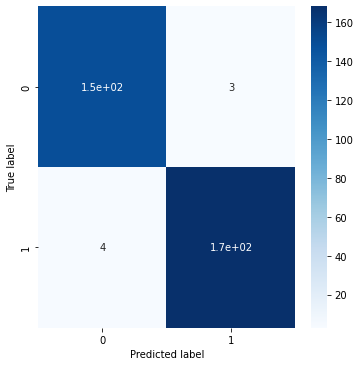

In [ ]:
# посторение confusion matrix
labels = np.array([1 if os.path.dirname(path).split('/')[-1].startswith('Fire') else 0 for path in test_files])
con_mat = tf.math.confusion_matrix(labels=labels, predictions=np.around(test_pred)).numpy()
# con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat, index = [0,1], columns = [0,1])

print(con_mat_df)

# визуализация confusion matrix
figure = plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# формируем датасет с результатами и сохраняем в файл csv
ids = []
folder = []
prob = []
for path, score in zip(test_files, np.around(test_pred)):
    ids.append((os.path.basename(path)))
    folder.append((os.path.dirname(path).split('/')[-1]))
    prob.append(score[0])

output = pd.DataFrame({'id': ids, 'folder': folder, 'label': prob})
output.to_csv('gdrive/MyDrive/Fire_detecting/submission.csv', index=False)
output.head(20)

,id,folder,label
0,fire.533.png,Fire images 2,1.0
1,fire.335.png,Fire images 2,1.0
2,9544.jpg,Normal Images 1,0.0
3,fire.355.png,Fire images 2,1.0
4,fire.502.png,Fire images 2,1.0
5,fire.659.png,Fire images 2,1.0
6,grimstad_panorama.jpg,Normal Images 2,0.0
7,fire.245.png,Fire images 2,1.0
8,b3ba28f17af4917649fe0c08bc523922.jpg,Normal Images 2,0.0
9,fire.672.png,Fire images 2,1.0
